In [ ]:
# !apt-get install -y xvfb python-opengl > /dev/null 2>&1
# !pip install gym pyvirtualdisplay > /dev/null 2>&1

# from google.colab import drive
# drive.mount('/content/drive')

import gym
import numpy as np
import tensorflow as tf
import keras
from keras.layers import Dense
from keras import Input
from keras.models import Model
import matplotlib.pyplot as plt
import random
import pickle
import time
import cv2
from google.colab.patches import cv2_imshow

Using TensorFlow backend.


In [ ]:
class ReplayMemory:
    def __init__(self, max_size):
        self.buffer = [None] * max_size
        self.max_size = max_size
        self.index = 0
        self.size = 0

    def append(self, obj):
        self.buffer[self.index] = obj
        self.size = min(self.size + 1, self.max_size)
        self.index = (self.index + 1) % self.max_size

    def sample(self, batch_size):
        indices = random.sample(range(self.size), batch_size)
        return [self.buffer[index] for index in indices]

In [ ]:
class Model:
    def __init__(self, frame_size, num_actions):
        self.model = keras.Sequential()
        self.model.add(Dense(256, activation = 'relu', input_shape = (frame_size*128, )))
        self.model.add(Dense(128, activation = 'relu'))
        self.model.add(Dense(128, activation = 'relu'))
        self.model.add(Dense(num_actions))
        self.model.compile(optimizer = keras.optimizers.Adam(learning_rate = 0.00001), loss = 'mse', metrics = ['accuracy'])

In [ ]:
class Agent:
    def __init__(self, agent_params):
        self.discount = agent_params['discount']
        self.epsilon = agent_params['epsilon']
        self.num_actions = agent_params['num_actions']
        self.exp_size = agent_params['exp_size']
        self.frame_size = agent_params['frame_size']
        self.merge = agent_params['merge_threshold']
        self.batch_size = agent_params['batch_size']
        self.last_action = None
        self.last_state = None
        self.exp = ReplayMemory(self.exp_size)
        self.frames = np.zeros((1, self.frame_size*128))
        self.target_model = Model(self.frame_size, self.num_actions)
        self.value_model = Model(self.frame_size, self.num_actions)
        self.num_updates = 0
        self.num_steps = 0
        self.num_games = 0
        self.num_merge = 0
        self.waste = 0
        self.lives = agent_params['lives']
        self.target_model.model.set_weights(self.value_model.model.get_weights())
  
    def phi(self, state):
        new = self.frames[:, 128:].copy()
        new = np.concatenate([new, state/255.0], axis = -1)
        self.frames = new.copy()
        return self.frames
    
    def phi_init(self):
        self.frames = np.zeros((1, self.frame_size*128))

    def run(self):
        updates = min(self.batch_size, self.exp.size)
        self.num_updates += updates
        batch = self.exp.sample(updates)

        input = [x[0] for x in batch]
        inp = [x[3] for x in batch]
        x_train = np.concatenate(input, axis = 0)
        y_train = self.value_model.model.predict(x_train)
        target_action = np.argmax(y_train, axis = 1)
        x_target = np.concatenate(inp, axis = 0)
        y_target = self.target_model.model.predict(x_target)

        for count, memory in enumerate(batch):
            last_state, last_action, reward, state, terminal = memory
            y_train[count][last_action] = reward + self.discount*y_target[count][target_action[count]]*(1 - terminal)

        self.value_model.model.fit(x_train, y_train, verbose = 0, epochs = 1)

        if self.num_steps % self.merge == 0:
            self.merge_model()

    def merge_model(self):
        self.target_model.model.set_weights(self.value_model.model.get_weights())
        self.num_merge += 1

    def epsilon_decay(self):
        if self.epsilon >= 0.05:
            if self.num_steps >= 50000:
                if self.num_steps <= 1050000:
                    self.epsilon -= 0.9/1000000
                elif self.num_steps <= 2050000:
                    self.epsilon -= 0.05/1000000

    def choose_action(self, state):
        if np.random.random() < self.epsilon:
            action = np.random.choice(self.num_actions)
        else:
            action = np.argmax(self.value_model.model.predict(state)[0])

        self.num_steps += 1
        self.epsilon_decay()
        return action

    def agent_start(self, env_state):
        self.lives = 5
        self.phi_init()
        state = self.phi(env_state)
        self.last_action = self.choose_action(state)
        self.last_state = state
        return self.last_action

    def agent_step(self, reward, env_state, lives):
        state = self.phi(env_state)
        if self.waste:
            self.waste = 0
        elif self.lives > lives:
            self.lives = lives
            memory = (self.last_state, self.last_action, reward, state, 1)
            self.phi_init()
            self.exp.append(memory)
        else:
            memory = (self.last_state, self.last_action, reward, state, 0)
            self.exp.append(memory)
        self.run()
        self.last_action = self.choose_action(state)
        self.last_state = state
        return self.last_action

    def agent_end(self, reward):
        memory = (self.last_state, self.last_action, reward, np.zeros((1, 512)), 1)
        self.exp.append(memory)
        self.run()
        self.num_games += 1

    def check(self, states):
        y = np.mean(np.max(self.value_model.model.predict(states), axis = 1))
        return y

In [ ]:
agent_params = {
    'discount' :0.99,
    'epsilon' :1.0,
    'num_actions' : 4,
    'exp_size': 600000,
    'frame_size' : 4,
    'merge_threshold' : 10000,
    'batch_size' : 32,
    'lives' : 5
}
agent = Agent(agent_params)
episodes = []
q_value = []
avg_reward = []

env = gym.make('Breakout-ramDeterministic-v4')
print(env.action_space)

Discrete(4)


In [ ]:
indices = np.random.choice(agent.exp.size, 20000)
test_states = np.zeros((20000, 512))
for count, index in enumerate(indices):
    test_states[count, :] = agent.exp.buffer[index][0]

In [ ]:
def save(num_games):  
    val = 1
    if num_games % 400 == 0:
        val = 0
    data = (episodes, q_value, avg_reward, test_states)
    with open('/content/drive/My Drive/DDQN/auxiliary' + str(val) + '.pkl', 'wb') as f:
        pickle.dump(data, f)
    with open('/content/drive/My Drive/DDQN/agent' + str(val) + '.pkl', 'wb') as f:
        pickle.dump(agent, f)

In [ ]:
def load(val):
    global agent, episodes, q_value, avg_reward, test_states
    with open('/content/drive/My Drive/DDQN/auxiliary' + str(val) + '.pkl', 'rb') as f:
        data = pickle.load(f)
    episodes, q_value, avg_reward, test_states = data
    with open('/content/drive/My Drive/DDQN/agent' + str(val) + '.pkl', 'rb') as f:
        agent = pickle.load(f)

In [ ]:
def plot(num_games, total):
    episodes.append(num_games)
    q_value.append(agent.check(test_states))
    avg_reward.append(total)
    return 0

In [ ]:
def record(out):
    image = env.unwrapped._get_image()
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    out.write(image)
    return out

In [ ]:
def train(agent, env):
    load(0)
    num_games = 20
    total = 0
    sum = 0
    for _ in range(1, num_games+1):
        # fourcc = cv2.VideoWriter_fourcc(*'XVID')
        # out = cv2.VideoWriter('/content/drive/My Drive/output' + str(_) + '.avi',fourcc,20, (160, 210))
        action = agent.agent_start(env.reset().reshape((1, 128)))
        observations, reward, done, info = env.step([action])
        # out = record(out)
        total += reward
        sum += reward

        while not done:
            observations, reward, done, info = env.step([agent.agent_step(reward, observations.reshape((1, 128)), env.ale.lives())])
            # out = record(out)
            total += reward
            sum += reward
        agent.agent_end(reward)
        print(total)
        total = 0

        if agent.num_games % 50 == 0:
            total = plot(agent.num_games, total/50)
            if agent.num_games % 100 == 0:
                print('Games = {}, Steps = {}, Reward = {}'.format(_, agent.num_steps, sum/100))
                sum = 0
                if agent.num_games % 200 == 0:
                    save(agent.num_games)

In [ ]:
def evaluate():
    print(agent.num_games)
    print(agent.num_steps)
    print(agent.epsilon)
    print(np.max(agent.value_model.model.get_weights()[0]))
    _, ax = plt.subplots(1, 2, figsize = (10, 5))
    ax[0].plot(episodes, q_value)
    ax[1].plot(episodes, avg_reward)
    plt.show()

22200
22983526
0.04999995000814758
2.8032796


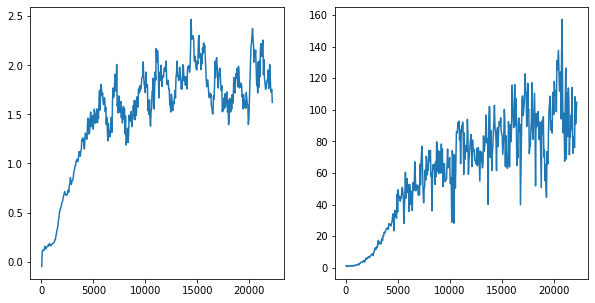

In [ ]:
load(0)
evaluate()

In [ ]:
class Performer:
    def __init__(self, performer_params):
        self.num_actions = performer_params['num_actions']
        self.frame_size = performer_params['frame_size']
        self.last_action = None
        self.frames = np.zeros((1, self.frame_size*128))
        self.predict_model = Model(self.frame_size, self.num_actions)
        self.num_steps = 0
        self.lives = agent_params['lives']
        self.epsilon = performer_params['epsilon']
  
    def phi(self, state):
        new = self.frames[:, 128:].copy()
        new = np.concatenate([new, state/255.0], axis = -1)
        self.frames = new.copy()
        return self.frames
    
    def phi_init(self):
        self.frames = np.zeros((1, self.frame_size*128))

    def choose_action(self, state):
        if np.random.random() < self.epsilon:
            action = np.random.choice(self.num_actions)
        else:
            action = np.argmax(self.predict_model.model.predict(state)[0])
        self.num_steps += 1
        return action

    def agent_start(self, env_state):
        self.lives = 5
        self.phi_init()
        state = self.phi(env_state)
        self.last_action = self.choose_action(state)
        return self.last_action

    def agent_step(self, reward, env_state, lives):
        state = self.phi(env_state)
        if self.lives > lives:
            self.lives = lives
            self.phi_init()
        self.last_action = self.choose_action(state)
        return self.last_action

In [ ]:
performer = Performer(performer_params = {'num_actions' : 4, 'frame_size'  : 4, 'lives' : 5, 'epsilon' : 0.01})

In [ ]:
performer.predict_model.model.set_weights(agent.target_model.model.get_weights())

In [ ]:
def perform(performer, env):
    num_games = 20
    for i in range(2, num_games+1):
        fourcc = cv2.VideoWriter_fourcc(*'XVID')
        out = cv2.VideoWriter('/content/drive/My Drive/out' + str(i) + '.avi',fourcc,20, (160, 210))  
        total = 0
        action = performer.agent_start(env.reset().reshape((1, 128)))
        observations, reward, done, info = env.step([action])
        total += reward
        image = env.unwrapped._get_image()
        image = cv2.cvtColor(image,cv2.COLOR_RGB2BGR)
        out.write(image)

        while not done:
            observations, reward, done, info = env.step([performer.agent_step(reward, observations.reshape((1, 128)), env.ale.lives())])
            total += reward
            image = env.unwrapped._get_image()
            image = cv2.cvtColor(image,cv2.COLOR_RGB2BGR)
            out.write(image)
        print('Game {}, Score = {}, Steps = {}'.format(i, total, performer.num_steps))

In [ ]:
perform(performer, env)

Game 2, Score = 48.0, Steps = 1146
Game 3, Score = 33.0, Steps = 1896
Game 4, Score = 65.0, Steps = 3313
Game 5, Score = 357.0, Steps = 5334
Game 6, Score = 55.0, Steps = 6563
Game 7, Score = 215.0, Steps = 8109
Game 8, Score = 361.0, Steps = 10163
Game 9, Score = 331.0, Steps = 12088
Game 10, Score = 331.0, Steps = 14013
Game 11, Score = 105.0, Steps = 15612
Game 12, Score = 120.0, Steps = 17249
Game 13, Score = 44.0, Steps = 18295
Game 14, Score = 339.0, Steps = 20380
Game 15, Score = 49.0, Steps = 21569
Game 16, Score = 83.0, Steps = 22703
Game 17, Score = 331.0, Steps = 24628
Game 18, Score = 362.0, Steps = 27077
Game 19, Score = 328.0, Steps = 29490
Game 20, Score = 60.0, Steps = 30835
